# Calculate the TSN intrinsic value

In [49]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from ipynb.fs.full.c_Stock_visual_QC import read_data_from_sql          # import function from other .ipynb file
pd.options.mode.chained_assignment = None # not to get SettingWithCopyWarning

import warnings
import statsmodels.api as sm

## To Set Vriables please scroll down...

## Function to use

In [50]:
def calculate_missing_columns(df):
    # derived columns
    df['tot_liab'] = df['tot_ass'] - df['tot_equity']
    df['inc_b_tax'] = df['net_inc'] + df['inc_tax_exp']
    df['ebitda'] = df['rev'] - df['cost_sale'] - df['sale_gen_adm']
    df['ebit'] = df['ebitda'] - df['depr_amort']
    df['nopat'] = df['ebit'] - df['inc_tax_exp']
    df['other_curr_ass_lesscash'] = df['acc_rec'] + df['invent'] + df['other_curr_ass']
    df['tot_curr_liab_lessdebt'] = df['tot_curr_liab'] - df['short_debt']
    df['nwc'] = df['other_curr_ass_lesscash'] - df['tot_curr_liab_lessdebt']
    # capex calculation
    capex = []
    for index in range(len(df)):
        if index > 0:
            ppe_change = df['ppe_net'].iloc[index] - df['ppe_net'].iloc[index-1]
            depr_amort = df['depr_amort'].iloc[index]
            capex.append(ppe_change + depr_amort)
        else:
            capex.append(np.nan)
    df.loc[:, 'capex'] = capex

    return df

In [51]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    from statsmodels.tsa.arima.model import ARIMA
    from sklearn.metrics import mean_squared_error
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    print(error)
    return error

In [52]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [53]:
# create a function to calculate ratios
def calculate_is_margins(df):
    is_incomes = ['cost_sale', 'sale_gen_adm']
    calc_margins = dict()
    # plot and calculate ratios
    for income in is_incomes:
        if income != 'inc_tax_exp':
            div = 'rev'
        else:
            div = 'inc_b_tax'

        fig, ax1 = plt.subplots(figsize=(15, 6))

        ax1.plot(df['end'], df[income]/df[div], label=income.replace('_', ' ').upper())
        ax1.axhline(y=(df[income]/df[div]).mean(), color='r', label='Average value')
        
        ax1.set_xlabel('Date')
        ax1.set_ylabel(income.replace('_', ' ').upper())
        
        plt.legend()
        plt.show()

        calc_margins[income+'_margin'] = (df[income]/df[div]).mean()

        print(str(income)+' is divided by the revenue.')
        print('Average value: '+str((df[income]/df[div]).mean()))

    return calc_margins

In [54]:
def predict_cos_sale_gen_adm(input_df, is_ratio_dictionary):
    # predict Cost Of Sales & Sale, General Administration from the Revenue
    for column in ['cost_sale', 'sale_gen_adm']:
        input_df[column] = input_df['rev'] * is_ratio_dictionary[column+'_margin']

    return input_df

In [55]:
def fixed_asset_ratios(df):
    # calculate PPE start & CAPEX
    df['ppe_net_start'] = [df['ppe_net'].values[i-1] if i > 0 else np.nan for i in range(len(df['ppe_net'].values))]
    df['capex'] = df['ppe_net'] - df['ppe_net_start'] + df['depr_amort']
    
    #calculate ratio
    fixed_asset_ratios = dict()
    # D&A ratio
    for column in ['depr_amort', 'capex']:
        ratio = df[column]/df['ppe_net_start']
        ratio.hist()
        plt.show()
        fixed_asset_ratios[column+'_ratio'] = ratio.mean()
        print('Average', column, 'value is', fixed_asset_ratios[column+'_ratio'])
    return fixed_asset_ratios

In [56]:
def predict_fixed_assets(raw_df, prediction_df, fxd_ass_ratios):
    # get the last measured PPE as start in case of prediction
    ppe_start_pred = [raw_df['ppe_net'].iloc[-1]]
    depr_amort_pred = []
    capex_pred = []
    ppe_net = []
    # calculate prediction
    for index in range(len(prediction_df)):
        depr_amort_pred.append(ppe_start_pred[-1] * fxd_ass_ratios['depr_amort_ratio'])
        capex_pred.append(ppe_start_pred[-1] * fxd_ass_ratios['capex_ratio'])
        ppe_net.append(ppe_start_pred[-1] - depr_amort_pred[-1] + capex_pred[-1])
        # add the last PPE as starting to the PPE start
        ppe_start_pred.append(ppe_net[-1])
    
    prediction_df['depr_amort'] = depr_amort_pred
    prediction_df['capex'] = capex_pred
    prediction_df['ppe_net'] = ppe_net

    return prediction_df

In [57]:
def calc_eff_tax_rate(df):
    if df['end'].iloc[-1] > pd.Timestamp('2017-01-01'):
        eff_tax_rate = 0.21
    else:
        eff_tax_rate = (df['inc_tax_exp']/df['ebit']).mean()
        # plot
        (df['inc_tax_exp']/df['ebit']).hist(range=[0, 1])
        plt.show()

    print('Effective tax rate is', eff_tax_rate)
    return eff_tax_rate

In [58]:
def calculate_ebitda_ebit_nopat(prediction_df, eff_tax_rate):
    prediction_df['ebitda'] = prediction_df['rev'] - prediction_df['cost_sale'] - prediction_df['sale_gen_adm']
    prediction_df['ebit'] = prediction_df['ebitda'] - prediction_df['depr_amort']
    prediction_df['nopat'] = prediction_df['ebit'] - (prediction_df['ebit'] * eff_tax_rate)
    return prediction_df

In [59]:
def plot_hist_pred(hist_df, pred_df):
    # reset index
    pred_df.index = [i for i in range(len(hist_df), len(hist_df) + len(pred_df))]
    
    for column in pred_df.columns:
        try:
            fig, ax1 = plt.subplots(figsize=(15, 6))

            ax1.plot(hist_df.index, hist_df[column], color='k', label='Historical data')
            ax1.plot(pred_df.index, pred_df[column], color='r', label='Predicted values')

            ax1.set_xlabel('Index')
            ax1.set_ylabel(column.replace('_', ' ').upper())

            plt.legend()
            plt.show()
        except:
            continue

In [60]:
def calculate_nwc_ratios(df):
    result = dict()
    # Days Sales Outstanding (dso)
    dso = (df['acc_rec'] / df['rev']) * 360
    dso.hist()
    plt.show()
    result['dso'] = dso.mean()
    print('DSO:', result['dso'])

    #Days Inventory Out. (dis)
    dio = (df['invent'] / df['cost_sale']) * 360
    dio.hist()
    plt.show()
    result['dio'] = dio.mean()
    print('DIO:', result['dio'])

    #Days Payable Out. (dpo)
    dpo = (df['acc_pay'] / df['cost_sale']) * 360
    dpo.hist()
    plt.show()
    result['dpo'] = dpo.mean()
    print('DPO:', result['dpo'])


    #Sum of Other current assets per revenue --> soca_rev
    # calculate the non cach non accoint recivable and inventory total current assets ratio to revenue
    soca_rev = (df['tot_curr_ass'] - df['acc_rec'] - df['invent'] - df['cash_cash_eq']) / df['rev']
    soca_rev.hist()
    plt.show()
    result['soca_rev'] = soca_rev.mean()
    print('Sum Other Current Assets:', result['soca_rev'])

    #Sum of Other current liabilities per revenue --> socl_rev
    # calculate the non current debt non account payable total current liabilities ratio to revenue
    socl_rev = (df['tot_curr_liab'] - df['short_debt'] - df['acc_pay']) / df['rev']
    socl_rev.hist()
    plt.show()
    result['socl_rev'] = socl_rev.mean()
    print('Sum Other Current Liabilities per Rec', result['socl_rev'])
    
    return result

In [61]:
def predict_curr_ass_liab(df_prediction, nwc_ratios):
    # calculate assets, liabilities, and net working capital from NWC ratio
    df_prediction['acc_rec'] = (df_prediction['rev'] * nwc_ratios['dso']) / 360
    df_prediction['invent'] = (df_prediction['cost_sale'] * nwc_ratios['dio']) / 360
    df_prediction['acc_pay'] = (df_prediction['cost_sale'] * nwc_ratios['dpo']) / 360
    
    df_prediction['other_curr_ass_lesscash'] = df_prediction['acc_rec'] + df_prediction['invent'] + (df_prediction['rev'] * nwc_ratios['soca_rev'])
    df_prediction['tot_curr_liab_lessdebt'] = df_prediction['acc_pay'] + (df_prediction['rev'] * nwc_ratios['socl_rev'])
    df_prediction['nwc'] = df_prediction['other_curr_ass_lesscash'] - df_prediction['tot_curr_liab_lessdebt']
    return df_prediction

In [62]:
def calc_change_nwc(df_hist, df_predict):
    c_nwc = []
    # check the 2 DataFrame is equal & calculate NWC for measured data
    if df_hist.equals(df_predict):
        for index in range(len(df_predict)):
            if index > 0:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_predict['nwc'].iloc[index-1])
            else:
                c_nwc.append(np.nan)
    # calculate NWC for future data
    else:
        for index in range(len(df_predict)):
            if index > 0:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_predict['nwc'].iloc[index-1])
            else:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_hist['nwc'].iloc[-1])
    
    df_predict['c_nwc'] = c_nwc
    
    return df_predict

In [63]:
def calc_unleveared_fcf(df):
    df['unlev_fcf'] = df['nopat'] + df['depr_amort'] - df['capex'] - df['c_nwc']
    return df

In [64]:
def calculate_wacc(df, share_price, eff_tax_rate, us_bond_10_yr, equity_risk_premium, beta):
    equity = (share_price * df['shares'].iloc[-1])
    debt = df['short_debt'].iloc[-1] + df['tot_long_debt'].iloc[-1]
    
    cost_of_debt = abs(df['int_exp'].iloc[-1]) / debt
    d_per_d_plus_e = debt / (debt + equity)
    after_tax_cost_of_debt = cost_of_debt * (1 - eff_tax_rate)

    risk_free_rate = us_bond_10_yr
    market_risk_premium = equity_risk_premium
    cost_of_equity = risk_free_rate + (beta * market_risk_premium)
    e_per_d_plus_e = equity / (debt + equity)
    
    wacc = (d_per_d_plus_e * after_tax_cost_of_debt) + (e_per_d_plus_e * cost_of_equity)
    return wacc

In [65]:
def calculate_present_value_fcf(df, wacc, report='10-Q'):
    if report == '10-Q':
        multipl = 0.25
    else:
        multipl = 1
    # calculate present cahs flows
    df['pres_val_fcf'] = df['unlev_fcf']/((1+wacc)**(df.index*multipl))
    return df

In [66]:
def calculate_tv_prestv_enterp_val(df, industry_growth_rate, wacc):
    # Terminal Value
    tv = ((df['unlev_fcf'].iloc[-1] * (1 + industry_growth_rate))) / (wacc - industry_growth_rate)
    # present value of TV
    pres_value_tv = tv / (1 + wacc)**5
    
    return tv, pres_value_tv

In [67]:
def calc_enterp_company_value(df_hist, df_pred, pres_value_tv):
    
    debt = df_hist['short_debt'].iloc[-1] + df_hist['tot_long_debt'].iloc[-1]
    
    if 'equity_minor_interest' in df_hist.columns:
        equity_minor_interest = df_hist['equity_minor_interest'].iloc[-1]
    else:
        equity_minor_interest = 0
    # Enterprise Values
    enterp_val = df_pred['pres_val_fcf'].sum() + pres_value_tv
    # Company Value
    comp_val = enterp_val + df_hist['cash_cash_eq'].iloc[-1] - debt - equity_minor_interest
    

    print(enterp_val, comp_val)
    return enterp_val, comp_val

In [68]:
def implied_share_price(equity_value, hist_df):
    share_price = equity_value / hist_df['shares'].iloc[-1]
    return share_price

## 1. Set boundary parameters (stock price, prediction period, bond yield) & Load Data

In [69]:
# fixed parameters
db_path = '../database/statements.db'
form = '10-Q'
# end date years ago
finished_years_ago = 0
# forecast period
forecast_period = 20
# WACC input
share_price = 56
us_bond_10_yr = 0.0436
# country specifc - USA data from https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/ctryprem.html - 5.5% 10+ yrs average
equity_risk_premium = 0.055
beta = 0.55
# country industry growth rate - US GDP growth avg from 1948 yo 2023 - 3.12%
industry_growth_rate = 0.0312

In [70]:
#load data
data = read_data_from_sql(
    db_path=db_path,
    tickers=['KO'],
    statements=['income_statement', 'balance_sheet']    
)
print('Data are available from:', data['end'].iloc[0])
# start date 7 year earlier than end date
start_date = pd.Timestamp(datetime.date.today()) - (pd.Timedelta(days=(10 * 365) + (finished_years_ago * 365)))
end_date = pd.Timestamp(datetime.date.today()) - (pd.Timedelta(days=finished_years_ago * 365))
# create DataFrame
data_filt = data.loc[(data['form'] == form) & (data['end'] > start_date) & (data['end'] < end_date), :]
data_filt.reset_index(drop=True, inplace=True)
print('Filtered data start at:', data_filt.end.iloc[0])
print('Filtered data finish at:', data_filt.end.iloc[-1])

Connection to SQLite DB successful!
Data has been collected!
Datatype has been updated!
Connection closed!
Data are available from: 2015-04-03 00:00:00
Filtered data start at: 2015-04-03 00:00:00
Filtered data finish at: 2023-06-30 00:00:00


In [71]:
data_filt.head()

,cik,ticker,end,form,rev,cost_sale,sale_gen_adm,inpairm,op_income,int_income,...,intang_ass,other_ass,tot_ass,short_debt,acc_pay,other_curr_liab,tot_curr_liab,tot_long_debt,other_liab,tot_equity
0,0000021344,KO,2015-04-03,10-Q,1.071100e+10,4.103000e+09,4.079000e+09,82000000.0,2.296000e+09,155000000.0,...,6.424000e+09,4.602000e+09,9.101600e+10,2.040000e+09,8.853000e+09,689000000.0,2.612300e+10,2.608700e+10,4.296000e+09,2.883700e+10
1,0000021344,KO,2015-07-03,10-Q,1.215600e+10,4.748000e+09,4.204000e+09,82000000.0,2.535000e+09,149000000.0,...,6.085000e+09,4.517000e+09,9.353800e+10,2.031000e+09,9.997000e+09,437000000.0,2.885200e+10,2.597700e+10,4.283000e+09,2.841800e+10
2,0000021344,KO,2015-10-02,10-Q,1.142700e+10,4.577000e+09,4.207000e+09,82000000.0,2.379000e+09,155000000.0,...,6.032000e+09,4.446000e+09,9.300800e+10,2.692000e+09,9.877000e+09,383000000.0,3.154500e+10,2.594900e+10,4.194000e+09,2.604900e+10
3,0000021344,KO,2015-12-31,10-Q,1.142700e+10,4.577000e+09,4.207000e+09,82000000.0,2.379000e+09,155000000.0,...,5.989000e+09,4.110000e+09,8.999600e+10,2.676000e+09,9.660000e+09,331000000.0,2.692900e+10,2.831100e+10,4.301000e+09,2.555400e+10
4,0000021344,KO,2016-04-01,10-Q,1.028200e+10,4.069000e+09,3.761000e+09,82000000.0,2.141000e+09,144000000.0,...,6.014000e+09,4.314000e+09,9.126300e+10,4.956000e+09,9.626000e+09,275000000.0,3.098700e+10,2.699000e+10,3.820000e+09,2.491400e+10


## 2. Calculate EBITDA, EBIT, NOPAT, CAPEX etc on hisorical data

In [72]:
data_filt = calculate_missing_columns(data_filt)
data_filt.head()

,cik,ticker,end,form,rev,cost_sale,sale_gen_adm,inpairm,op_income,int_income,...,tot_equity,tot_liab,inc_b_tax,ebitda,ebit,nopat,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc,capex
0,0000021344,KO,2015-04-03,10-Q,1.071100e+10,4.103000e+09,4.079000e+09,82000000.0,2.296000e+09,155000000.0,...,2.883700e+10,6.217900e+10,1.972000e+09,2.529000e+09,2.056000e+09,1.641000e+09,1.128500e+10,2.408300e+10,-1.279800e+10,NaN
1,0000021344,KO,2015-07-03,10-Q,1.215600e+10,4.748000e+09,4.204000e+09,82000000.0,2.535000e+09,149000000.0,...,2.841800e+10,6.512000e+10,4.358000e+09,3.204000e+09,2.731000e+09,1.481000e+09,1.135900e+10,2.682100e+10,-1.546200e+10,4.920000e+08
2,0000021344,KO,2015-10-02,10-Q,1.142700e+10,4.577000e+09,4.207000e+09,82000000.0,2.379000e+09,155000000.0,...,2.604900e+10,6.695900e+10,1.721000e+09,2.643000e+09,2.170000e+09,1.898000e+09,9.967000e+09,2.885300e+10,-1.888600e+10,-1.277000e+09
3,0000021344,KO,2015-12-31,10-Q,1.142700e+10,4.577000e+09,4.207000e+09,82000000.0,2.379000e+09,155000000.0,...,2.555400e+10,6.444200e+10,1.721000e+09,2.643000e+09,2.170000e+09,1.898000e+09,9.595000e+09,2.425300e+10,-1.465800e+10,4.290000e+08
4,0000021344,KO,2016-04-01,10-Q,1.028200e+10,4.069000e+09,3.761000e+09,82000000.0,2.141000e+09,144000000.0,...,2.491400e+10,6.634900e+10,1.884000e+09,2.452000e+09,1.994000e+09,1.593000e+09,1.051300e+10,2.603100e+10,-1.551800e+10,5.000000e+08


## 3. Forecast Revenue

Before the ARIMA / SARIMA modling need to know p, d, q values (model parameters):
- p: Trend autoregression order.
- q: Trend moving average order.
- d: Trend difference order.

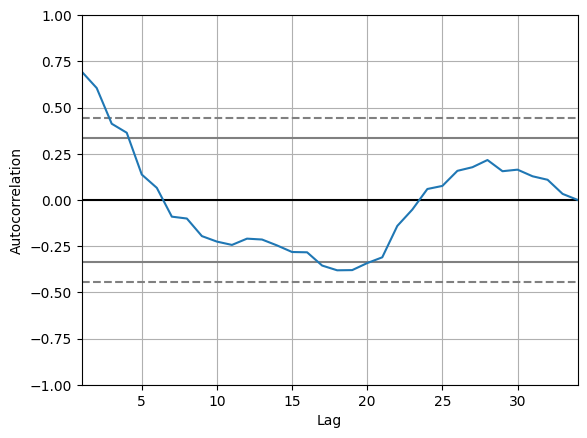

In [73]:
# Creating Autocorrelation plot - ACF
x = pd.plotting.autocorrelation_plot(data_filt['rev'])
x.plot()
plt.show()

The monotony of ACF is changed first time there is the p value. 

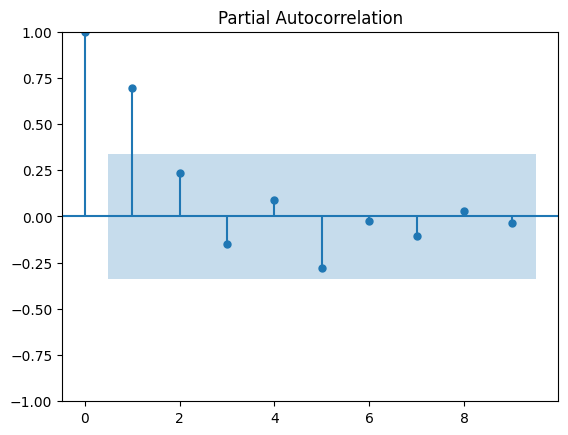

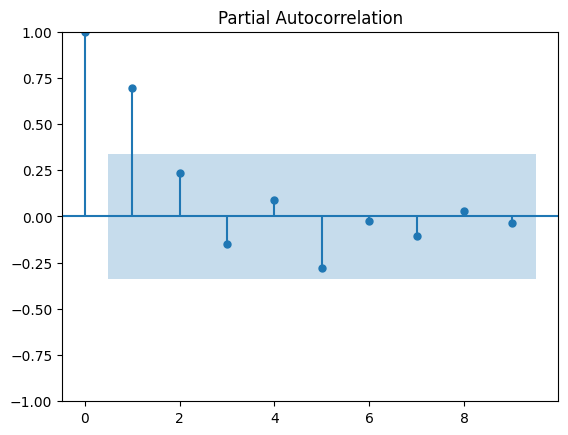

In [74]:
# Creating Partial Autocorrelation plot --> PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_filt['rev'], lags = int(forecast_period / 2 - 1))

Number of points, which are far away from the boundary is the q value.

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how a decide the q value. Hence the value of q is 2.

The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

I will find ARIMA hyperparameters (p, d, q) with gridsearch step-by-step

In [75]:
# evaluate an ARIMA model for a given order (p,d,q) ---> You can tip p and estimate d, q based on previous plots
series = data_filt['rev']
# evaluate parameters
p_values = [2, 4]
d_values = [1]
q_values = [1, 3]
warnings.filterwarnings("ignore")
best_config = evaluate_models(series.values, p_values, d_values, q_values)

5.468184531709028e+17
ARIMA(2, 1, 1) MSE=546818453170902784.000
5.657159163364148e+17
ARIMA(2, 1, 3) MSE=565715916336414784.000
5.581185031396083e+17
ARIMA(4, 1, 1) MSE=558118503139608320.000
5.579602135339833e+17
ARIMA(4, 1, 3) MSE=557960213533983296.000
Best ARIMA(2, 1, 1) MSE=546818453170902784.000


The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model.

The parameter "s" is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect. Here is hardcoded, works well with 12.

In [76]:
# float datatype is needed to SARIMAX model
data_filt['rev'] = data_filt['rev'].astype(float)

In [77]:
# use the model parameters of SARIMA
p, d, q = best_config
model=sm.tsa.statespace.SARIMAX(data_filt['rev'].values,
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40260D+01    |proj g|=  1.40835D+00


 This problem is unconstrained.



At iterate    5    f=  1.35394D+01    |proj g|=  9.60205D-02

At iterate   10    f=  1.35248D+01    |proj g|=  1.86958D-02

At iterate   15    f=  1.35217D+01    |proj g|=  3.93133D-03

At iterate   20    f=  1.35216D+01    |proj g|=  9.62798D-03

At iterate   25    f=  1.35211D+01    |proj g|=  1.53722D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     30      1     0     0   7.630D-05   1.352D+01
  F =   13.521101368998885     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:        

In [78]:
# use SARIMAX model
prediction_revenue = model.predict(len(data_filt), len(data_filt) + forecast_period)
# df from results
prediction = pd.DataFrame(
    prediction_revenue,
    index=[i+1 for i in range(len(prediction_revenue))],
    columns=['rev']
)

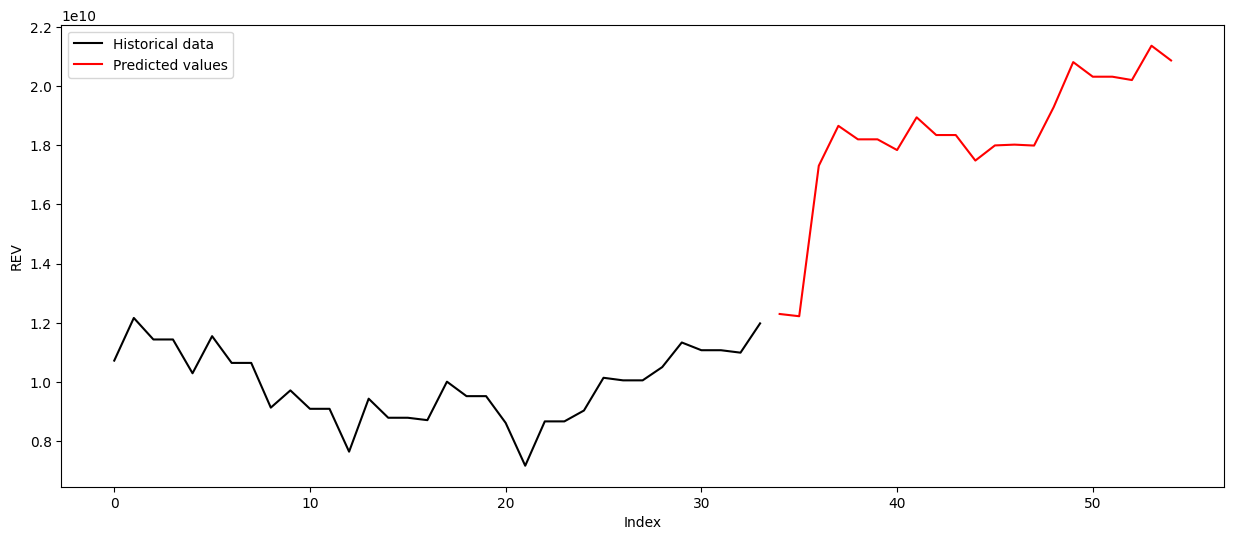

In [79]:
plot_hist_pred(data_filt, prediction)

## 4. Calculate ratios

After the revenue prediction I calculate the expenses and use those to predict future CoS and EBITDA.

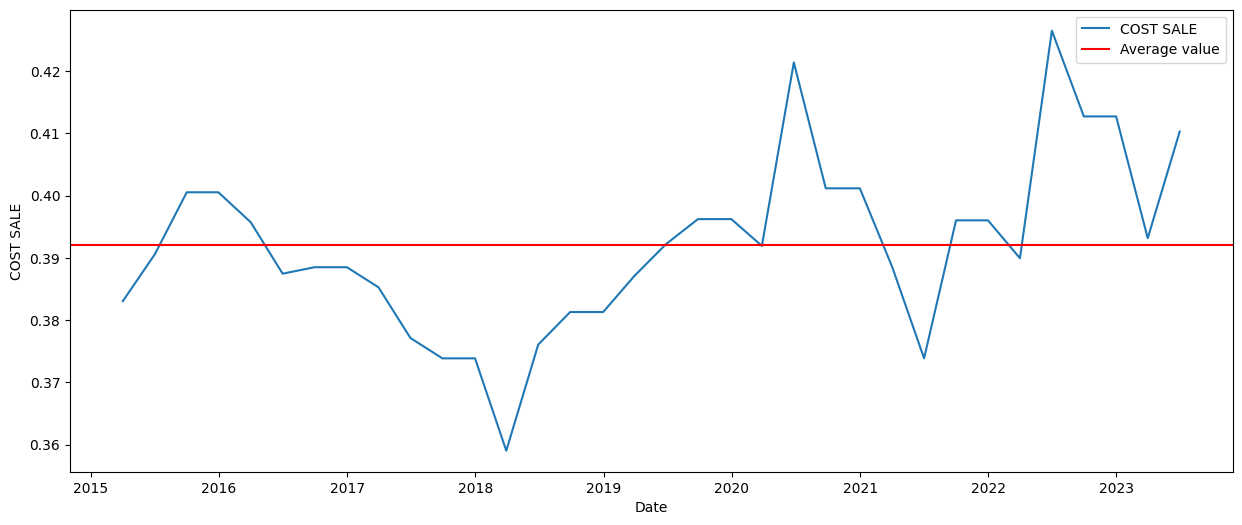

cost_sale is divided by the revenue.
Average value: 0.3920637184342591


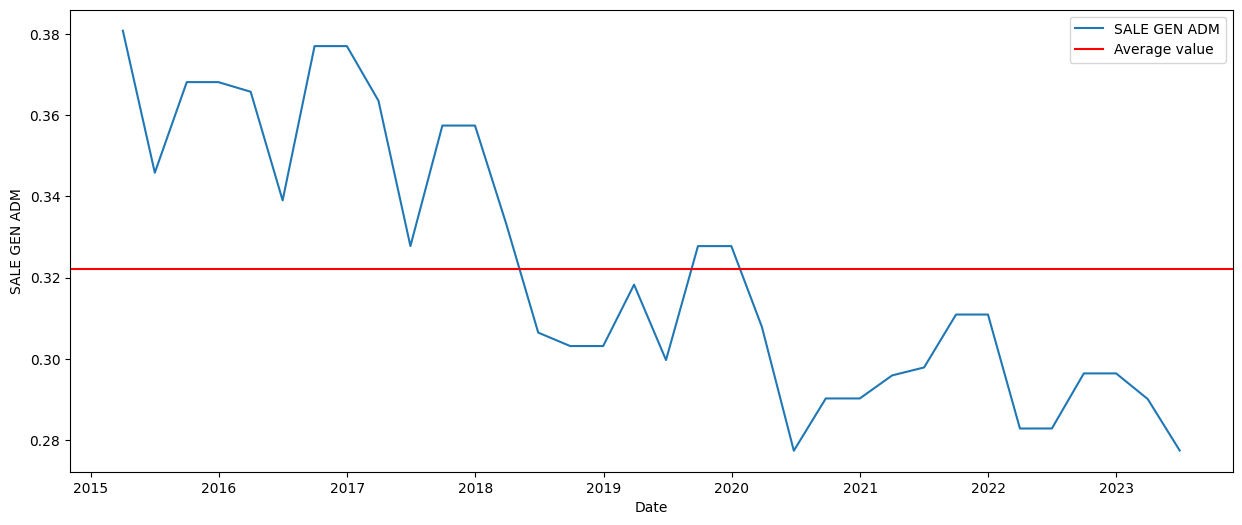

sale_gen_adm is divided by the revenue.
Average value: 0.3221940144262243


In [80]:
is_ratio_dictionary = calculate_is_margins(data_filt)

In [81]:
prediction = predict_cos_sale_gen_adm(prediction, is_ratio_dictionary)
prediction.tail()

,rev,cost_sale,sale_gen_adm
50,2.032866e+10,7.970129e+09,6.549772e+09
51,2.032882e+10,7.970191e+09,6.549823e+09
52,2.021562e+10,7.925812e+09,6.513352e+09
53,2.137831e+10,8.381658e+09,6.887962e+09
54,2.087875e+10,8.185800e+09,6.727008e+09


## 5. Calculate Fixed Assets

It's time to calculate D&A costs.

I will predict the PPE, D&A and CapEx values together.

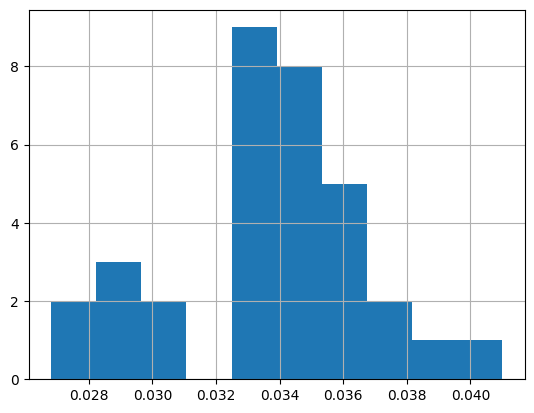

Average depr_amort value is 0.03379849682627108


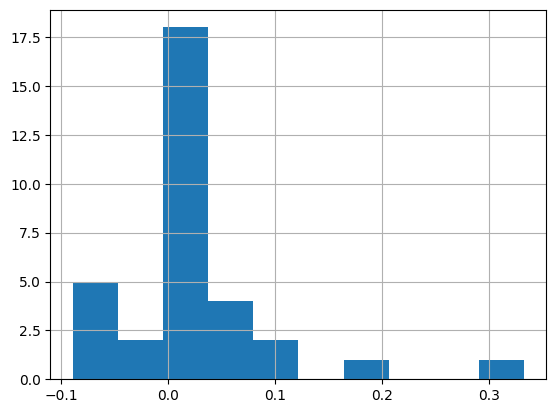

Average capex value is 0.024609017098108647


In [82]:
fxd_ass_ratios = fixed_asset_ratios(data_filt)

In [83]:
prediction = predict_fixed_assets(data_filt, prediction, fxd_ass_ratios)
prediction.head()

,rev,cost_sale,sale_gen_adm,depr_amort,capex,ppe_net
34,1.229052e+10,4.818666e+09,3.959931e+09,3.280482e+08,2.388551e+08,9.616807e+09
35,1.221424e+10,4.788760e+09,3.935355e+09,3.250336e+08,2.366602e+08,9.528433e+09
36,1.731136e+10,6.787156e+09,5.577616e+09,3.220467e+08,2.344854e+08,9.440872e+09
37,1.866444e+10,7.317649e+09,6.013570e+09,3.190873e+08,2.323306e+08,9.354115e+09
38,1.820659e+10,7.138144e+09,5.866055e+09,3.161550e+08,2.301956e+08,9.268156e+09


## 6. Calculate EBITDA, EBIT, NOPAT

In [84]:
eff_tax_rate = calc_eff_tax_rate(data_filt)

Effective tax rate is 0.21


In [85]:
prediction = calculate_ebitda_ebit_nopat(prediction, eff_tax_rate)
prediction.head()

,rev,cost_sale,sale_gen_adm,depr_amort,capex,ppe_net,ebitda,ebit,nopat
34,1.229052e+10,4.818666e+09,3.959931e+09,3.280482e+08,2.388551e+08,9.616807e+09,3.511920e+09,3.183872e+09,2.515259e+09
35,1.221424e+10,4.788760e+09,3.935355e+09,3.250336e+08,2.366602e+08,9.528433e+09,3.490125e+09,3.165091e+09,2.500422e+09
36,1.731136e+10,6.787156e+09,5.577616e+09,3.220467e+08,2.344854e+08,9.440872e+09,4.946587e+09,4.624540e+09,3.653387e+09
37,1.866444e+10,7.317649e+09,6.013570e+09,3.190873e+08,2.323306e+08,9.354115e+09,5.333219e+09,5.014131e+09,3.961164e+09
38,1.820659e+10,7.138144e+09,5.866055e+09,3.161550e+08,2.301956e+08,9.268156e+09,5.202393e+09,4.886238e+09,3.860128e+09


## 7. Function to plot Prediction vs Historical data

See at the functions...

## 8. Calculate Net Working Capital

To get this we have to forecast the current assets and liabilities.
I will use ratios to predict them:
- Days Sales Outstanding (dso) --> (Account recivable / Revenue) * 360
- Days Inventory Outstanding (dio) --> (Inventory / Cost of General Sale) * 360
- Other current assets per revenue (oca_rev) --> Other current assets / revenue
- Current liabilities per revenue (tcl_rec) --> (Total current liabilities - current debt) / revenue

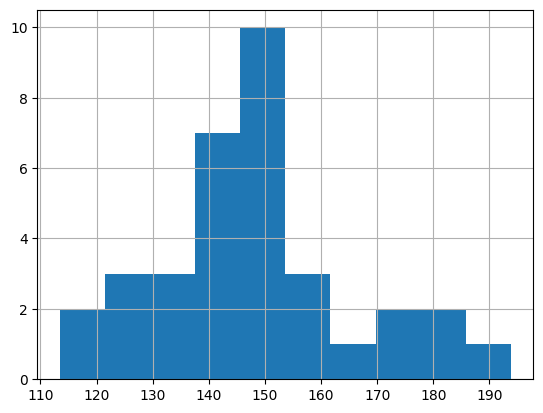

DSO: 148.6377725395046


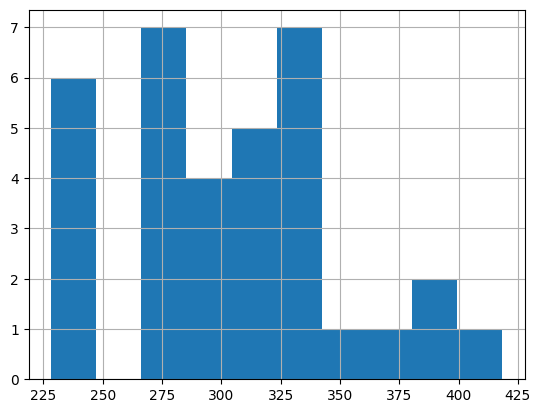

DIO: 305.010750042363


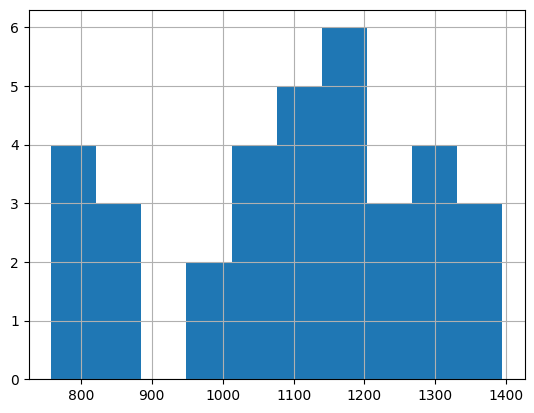

DPO: 1092.6510666134413


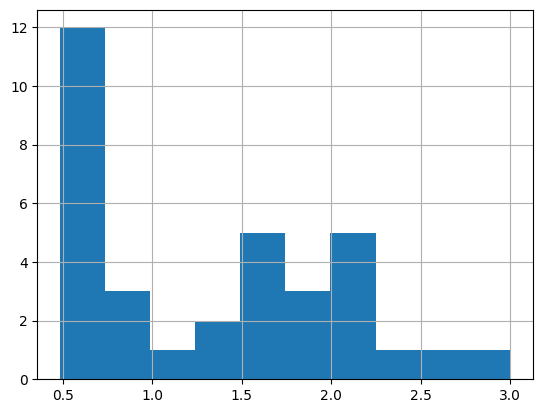

Sum Other Current Assets: 1.3359098188170575


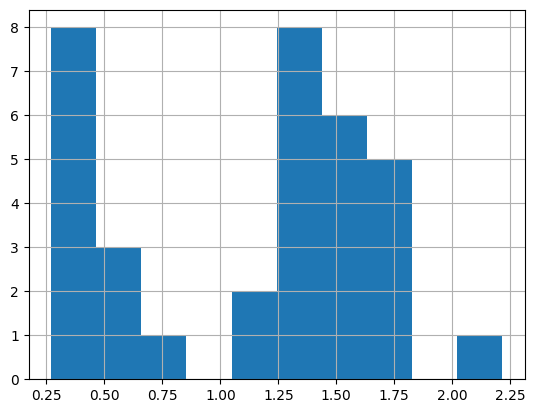

Sum Other Current Liabilities per Rec 1.1320173919171388


In [86]:
nwc_ratios = calculate_nwc_ratios(data_filt)

In [87]:
prediction = predict_curr_ass_liab(prediction, nwc_ratios)
prediction.head()

,rev,cost_sale,sale_gen_adm,depr_amort,capex,ppe_net,ebitda,ebit,nopat,acc_rec,invent,acc_pay,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc
34,1.229052e+10,4.818666e+09,3.959931e+09,3.280482e+08,2.388551e+08,9.616807e+09,3.511920e+09,3.183872e+09,2.515259e+09,5.074542e+09,4.082625e+09,1.462533e+10,2.557619e+10,2.853841e+10,-2.962225e+09
35,1.221424e+10,4.788760e+09,3.935355e+09,3.250336e+08,2.366602e+08,9.528433e+09,3.490125e+09,3.165091e+09,2.500422e+09,5.043048e+09,4.057287e+09,1.453457e+10,2.541746e+10,2.836130e+10,-2.943840e+09
36,1.731136e+10,6.787156e+09,5.577616e+09,3.220467e+08,2.344854e+08,9.440872e+09,4.946587e+09,4.624540e+09,3.653387e+09,7.147561e+09,5.750432e+09,2.059998e+10,3.602441e+10,4.019674e+10,-4.172333e+09
37,1.866444e+10,7.317649e+09,6.013570e+09,3.190873e+08,2.323306e+08,9.354115e+09,5.333219e+09,5.014131e+09,3.961164e+09,7.706223e+09,6.199893e+09,2.221010e+10,3.884012e+10,4.333857e+10,-4.498448e+09
38,1.820659e+10,7.138144e+09,5.866055e+09,3.161550e+08,2.301956e+08,9.268156e+09,5.202393e+09,4.886238e+09,3.860128e+09,7.517187e+09,6.047807e+09,2.166528e+10,3.788736e+10,4.227546e+10,-4.388099e+09


## 9. Change in NWC

In [88]:
prediction = calc_change_nwc(data_filt, prediction)
data_filt = calc_change_nwc(data_filt, data_filt)

In [89]:
prediction = calc_unleveared_fcf(prediction)
data_filt = calc_unleveared_fcf(data_filt)

## 10. Calculate Weighted Average Cost of Capital (WACC)

In [90]:
wacc = calculate_wacc(
    df=data_filt,
    share_price=share_price,
    eff_tax_rate=eff_tax_rate,
    us_bond_10_yr=us_bond_10_yr,
    equity_risk_premium=equity_risk_premium,
    beta=beta)

print('Estimated WACC value:', wacc)

Estimated WACC value: 0.06519669873844648


## 11. Present value of FCF, Terminal Value & present value of TV

In [91]:
prediction = calculate_present_value_fcf(prediction, wacc=wacc, report=form)
prediction.tail()

,rev,cost_sale,sale_gen_adm,depr_amort,capex,ppe_net,ebitda,ebit,nopat,acc_rec,invent,acc_pay,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc,c_nwc,unlev_fcf,pres_val_fcf
50,2.032866e+10,7.970129e+09,6.549772e+09,2.830006e+08,2.060555e+08,8.296227e+09,5.808757e+09,5.525756e+09,4.365347e+09,8.393351e+09,6.752709e+09,2.419047e+10,4.230331e+10,4.720287e+10,-4.899554e+09,1.193127e+08,4.322980e+09,1.962956e+09
51,2.032882e+10,7.970191e+09,6.549823e+09,2.804000e+08,2.041620e+08,8.219989e+09,5.808802e+09,5.528402e+09,4.367438e+09,8.393416e+09,6.752761e+09,2.419066e+10,4.230364e+10,4.720323e+10,-4.899592e+09,-3.808725e+04,4.443714e+09,1.986168e+09
52,2.021562e+10,7.925812e+09,6.513352e+09,2.778233e+08,2.022859e+08,8.144452e+09,5.776458e+09,5.498634e+09,4.343921e+09,8.346680e+09,6.715161e+09,2.405596e+10,4.206809e+10,4.694040e+10,-4.872310e+09,2.728176e+07,4.392177e+09,1.932379e+09
53,2.137831e+10,8.381658e+09,6.887962e+09,2.752702e+08,2.004270e+08,8.069609e+09,6.108686e+09,5.833416e+09,4.608398e+09,8.826733e+09,7.101378e+09,2.543952e+10,4.448760e+10,4.964014e+10,-5.152537e+09,-2.802270e+08,4.963469e+09,2.149514e+09
54,2.087875e+10,8.185800e+09,6.727008e+09,2.727406e+08,1.985851e+08,7.995453e+09,5.965941e+09,5.693201e+09,4.497629e+09,8.620475e+09,6.935436e+09,2.484507e+10,4.344804e+10,4.848017e+10,-5.032135e+09,1.204017e+08,4.451382e+09,1.897547e+09


## 12. Terminal Value and present value of TV

I use the perpetuity growth model

In [92]:
tv, pres_value_tv = calculate_tv_prestv_enterp_val(prediction, industry_growth_rate, wacc)
pres_value_tv

98458225445.62045

In [93]:
enterp_val, equity_value = calc_enterp_company_value(data_filt, prediction, pres_value_tv)

136375030094.86249 112142030094.86249


In [94]:
# adjusted with debt, cash, equity in minor interest
fcst_share_price_adjusted = implied_share_price(equity_value, data_filt)
print('Current adjusted share price:', fcst_share_price_adjusted)

Current adjusted share price: 25.83322508520214


In [95]:
fcst_share_price = implied_share_price(enterp_val, data_filt)
print('Current share price (not adjusted):', fcst_share_price)

Current share price (not adjusted): 31.415579381447245


In [96]:
#plot_hist_pred(data_filt, prediction)